# Evalaute Velocity and Direction Dependence
The goal of this notebook is to explore the velocity and direction dependence of stopping power, as predicted by the ML model

In [1]:
%matplotlib inline
import sys
import os
from tqdm import tqdm
from time import sleep
sys.path.append(os.path.abspath('/scratch/users/pdanie20/silicon/PD-stopping-power-ml'))
from matplotlib import pyplot as plt
from stopping_power_ml.integrator import TrajectoryIntegrator
import pickle as pkl
import pandas as pd
import numpy as np
import keras


2024-07-25 19:41:42.615821: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 19:41:42.616562: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 19:41:43.736512: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 19:41:45.226873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-07-25 19:41:52.161350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load TDDFT Data
We need the 100 channel and random direction

In [2]:
channel_data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'channel_traj.pkl')).query('average_range')

In [3]:
random_data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/silicon/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl'))

## Load the Model and Featurizer
The model is saved in Keras h5, and the featurizer is in the root directory

In [4]:
from tensorflow import keras
model = keras.models.load_model('model-random-and-channel.h5')

In [5]:
with open('featurizer.pkl', 'rb') as fp:
    featurizers = pkl.load(fp)

In [6]:
start_frame = pkl.load(open(os.path.join('..', 'Si_starting_frame.pkl'), 'rb'))

In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,017 (7.88 KB)

 Trainable params: 2,015 (7.87 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Make the Trajectory Integration Tool
This will black box the annoying parts of making the trajectories

In [8]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizers)

## Evaluate $\left<001\right>$ at Many Velocities
See how smoothly it varies and whether the difference between channel/not channel increases at higher velocities

In [9]:
channel_stopping = []
for gid, group in channel_data.groupby('directory'):
    channel_stopping.append({
        'velocity': group['velocity_mag'].mean(),
        'stopping': group['force'].mean()
    })
channel_stopping = pd.DataFrame(channel_stopping)

In [10]:
%%time
velocities = np.linspace(0.1, 5.5, 22)
stopping_power = [
    traj_int.compute_stopping_power([(2.539087/30.469),(5.078175/30.469),(-10.156350/30.469)], [0, 0, 1], v)[0]
    for v in tqdm(velocities)
]


  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:12<04:14, 12.11s/it]

  9%|▉         | 2/22 [00:22<03:36, 10.83s/it]

 14%|█▎        | 3/22 [00:35<03:51, 12.20s/it]

 18%|█▊        | 4/22 [00:47<03:36, 12.04s/it]

 23%|██▎       | 5/22 [00:52<02:38,  9.33s/it]

 27%|██▋       | 6/22 [01:02<02:32,  9.55s/it]

 32%|███▏      | 7/22 [01:12<02:25,  9.68s/it]

 36%|███▋      | 8/22 [01:22<02:17,  9.84s/it]

 41%|████      | 9/22 [01:30<02:00,  9.31s/it]

 45%|████▌     | 10/22 [01:36<01:40,  8.39s/it]

 50%|█████     | 11/22 [01:44<01:31,  8.31s/it]

 55%|█████▍    | 12/22 [01:51<01:17,  7.70s/it]

 59%|█████▉    | 13/22 [01:57<01:05,  7.33s/it]

 64%|██████▎   | 14/22 [02:04<00:56,  7.11s/it]

 68%|██████▊   | 15/22 [02:10<00:48,  6.90s/it]

 73%|███████▎  | 16/22 [02:15<00:37,  6.20s/it]

 77%|███████▋  | 17/22 [02:23<00:34,  6.81s/it]

 82%|████████▏ | 18/22 [02:28<00:24,  6.15s/it]

 86%|████████▋ | 19/22 [02:36<00:20,  6.77s/it]

 91%|█████████ | 20/22 [02:42<00:13,  6.66s/it]

 95%|█████████▌| 21/22 [02:49<00:06,  6.65s/it]

100%|██████████| 22/22 [02:53<00:00,  6.02s/it]

100%|██████████| 22/22 [02:53<00:00,  7.91s/it]

CPU times: user 2min 50s, sys: 910 ms, total: 2min 51s
Wall time: 2min 53s


## Run the Random Trajectory at Many Velocities
We are going to compute the average stopping power by evaluating the stopping force at every position along the trajectory with different speeds

In [11]:
random_stopping = []
for gid, group in random_data.groupby('directory'):
    random_stopping.append({
        'velocity': group['velocity_mag'].mean(),
        'stopping': group['force'].mean()
    })
random_stopping = pd.DataFrame(random_stopping)

In [12]:
def compute_random_stopping_power(speed: float) -> float:
    """Compute the stopping power for the random trajectory
    
    Args:
        speed: Magnitude of the velocity
    Returns:
        Stopping power
    """
    
    # Get the positions along the trajectory
    random_positions = random_data[random_data['file'].str.contains('v_1.5')].copy()
    
    # Update the velocity
    random_positions['velocity'] *= speed
    
    # Run the model
    featurizers.set_chunksize(None)
    x = featurizers.featurize_many(random_positions[['position', 'velocity']], pbar=False)
    forces = model.predict(np.array(x))
    return forces.mean()

In [13]:
%%time
stopping_power_random = [
    compute_random_stopping_power(v)
    for v in tqdm(velocities)
]

  0%|          | 0/22 [00:00<?, ?it/s]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


  5%|▍         | 1/22 [00:39<13:58, 39.93s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


  9%|▉         | 2/22 [01:18<12:59, 38.96s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 14%|█▎        | 3/22 [01:56<12:17, 38.81s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


 18%|█▊        | 4/22 [02:35<11:37, 38.77s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


 23%|██▎       | 5/22 [03:14<10:59, 38.77s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


 27%|██▋       | 6/22 [03:52<10:18, 38.64s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


 32%|███▏      | 7/22 [04:31<09:39, 38.62s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


 36%|███▋      | 8/22 [05:10<09:01, 38.66s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


 41%|████      | 9/22 [05:48<08:22, 38.69s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 45%|████▌     | 10/22 [06:27<07:44, 38.68s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


 50%|█████     | 11/22 [07:06<07:05, 38.65s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


 55%|█████▍    | 12/22 [07:44<06:26, 38.66s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


 59%|█████▉    | 13/22 [08:23<05:48, 38.70s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


 64%|██████▎   | 14/22 [09:01<05:09, 38.64s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


 68%|██████▊   | 15/22 [09:40<04:30, 38.63s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


 73%|███████▎  | 16/22 [10:19<03:51, 38.65s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


 77%|███████▋  | 17/22 [10:58<03:13, 38.71s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


 82%|████████▏ | 18/22 [11:36<02:34, 38.63s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


 86%|████████▋ | 19/22 [12:15<01:55, 38.63s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


 91%|█████████ | 20/22 [12:54<01:17, 38.68s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


 95%|█████████▌| 21/22 [13:32<00:38, 38.76s/it]

 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


100%|██████████| 22/22 [14:11<00:00, 38.69s/it]

100%|██████████| 22/22 [14:11<00:00, 38.70s/it]

CPU times: user 1min 56s, sys: 3min 38s, total: 5min 35s
Wall time: 14min 11s


## Plot both together
Show how the stopping powers on and off channels change differently as a function of velocity

/tmp/ipykernel_16642/886178962.py:7: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  tddft = ax.scatter([], [], marker='x', facecolor='k', edgecolor='k', label='TD-DFT')
/tmp/ipykernel_16642/886178962.py:8: UserWarning: You passed a edgecolor/edgecolors ('mediumblue') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(channel_stopping['velocity'], channel_stopping['stopping'], marker='x',
/tmp/ipykernel_16642/886178962.py:10: UserWarning: You passed a edgecolor/edgecolors ('crimson') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(random_stopping['velocity'], random_stopping['stopping'], marker='x',


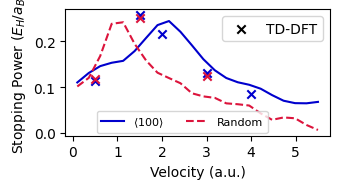

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ch, = ax.plot(velocities, stopping_power, color='mediumblue', label='Channel')
och, = ax.plot(velocities, stopping_power_random, '--', color='crimson', label='Off Channel')

# Add in the points for the channel
tddft = ax.scatter([], [], marker='x', facecolor='k', edgecolor='k', label='TD-DFT')
ax.scatter(channel_stopping['velocity'], channel_stopping['stopping'], marker='x',
                   facecolor='mediumblue', edgecolor='mediumblue', label='TD-DFT')
ax.scatter(random_stopping['velocity'], random_stopping['stopping'], marker='x',
                   facecolor='crimson', edgecolor='crimson', label='TD-DFT')

ax.set_xlabel('Velocity (a.u.)')
ax.set_ylabel('Stopping Power ($E_H / a_B$)')
#ax.set_ylim(0, 0.3)
#ax.set_xlim(0, 5)

l1 = ax.legend((ch, och), ('$\\left<100\\right>$', 'Random'), loc=(0.12, 0.02), ncol=2, fontsize=8)
ax.add_artist(l1)
ax.legend((tddft,), ('TD-DFT',))

fig.tight_layout()
fig.savefig(os.path.join('figures', 'on-vs-off-channel-multivelocity.png'), dpi=320)
fig.savefig(os.path.join('figures', 'on-vs-off-channel-multivelocity.pdf'))

*Finding*: The stopping power doesn't go to (0, 0), and does seem like it will converge to 0. But, the model does capture that the low velocity regime is linear and the difference between the channel and off chanell gets bigger at higher velocities before merging again at very high velocities.

Save the stopping power for the channels

In [15]:
channel_stopping.to_csv('stopping_power-100.csv', index=False)

In [16]:
random_stopping.to_csv('random_stopping_power-100.csv', index=False)